# Comparison of two time frames on where water was then compared to where water is now
This notebook is similar to the inundation mapping notebook. It links stream gauge data to satellite data and retrieves only the satellite images taken when the gauge was reading high-flow, allowing the user to study floods. This notebook allows the user to compare two time-frames for example, before a legislation was enforced and after it was enforced. The notebook generates a red and blue image showing the change in water occurance on floodplains and dams according to a certain date. 

## Imports and get data
This notebook accesses some back-end Python and XML files that scrape gauge data from the BoM Water Data Online website. They are located in the folder called Scripts. For ease of use, we have cached all the data so the code will run even if the BoM website is down. If you want to access the live BoM website, you can go into Scripts and move the stations.pkl file out of there so the code can't find it, and then it will go look on the real website instead of in the cache.  

In [1]:
%matplotlib inline

import os
import sys
import pickle
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
from datacube.storage import masking
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

sys.path.append('Scripts')
import dea_bom

dc = datacube.Datacube(app='Inundation_mapping')


#retrieving data
stations_pkl = Path('Scripts/stations.pkl')

# If cache exists, get station data from cache
if stations_pkl.exists():
    print('Loading from cache')
    stations = pickle.load(open(str(stations_pkl), 'rb'))
else:
    print('Fetching from BoM')
    stations = dea_bom.get_stations()
    pickle.dump(stations, open(str(stations_pkl), 'wb'))

# Filter list to stations with available data
stations_with_data = pickle.load(open(str('Scripts/stations_with_data.pkl'), 'rb'))
stations = [i for i in stations if i.name in stations_with_data]

# Preview the first five stations loaded
print(f'{len(stations)} stations loaded; e.g.:')
stations[:5]


Loading from cache
4305 stations loaded; e.g.:


[namespace(name='15 MILE @ GRETA STH', pos=(-36.61945775, 146.24407214), url='http://bom.gov.au/waterdata/services/stations/403213'),
 namespace(name='15 MILE @ WANGARATTA', pos=(-36.36666667, 146.2833333), url='http://bom.gov.au/waterdata/services/stations/403239'),
 namespace(name='16 Mile Waterhole', pos=(-18.876921, 139.360487), url='http://bom.gov.au/waterdata/services/stations/913010A'),
 namespace(name='163 Clifton Rd', pos=(-32.97808, 115.90111), url='http://bom.gov.au/waterdata/services/stations/6131318'),
 namespace(name='18 Mile Swamp HorseX', pos=(-27.49561971, 153.50836409), url='http://bom.gov.au/waterdata/services/stations/144005A')]

## Get the map
This cell generates a map with the gauges on it. Select a gauge to get flow data from. Make sure there is data available both before and after the legislation started. Click 'Done' once you have found a station with good data. If you forget to click 'Done', the rest of the code won't run. If you want to choose another gauge after you have clicked 'Done', re-run this cell. 

In [3]:
gauge_data, station = dea_bom.ui_select_station(stations)

## Make the Flow Duration Curve, Dask load satellite data and merge with gauge data
The lat and lon of the gauge will be automatically selected, but is changeable in the first line of code below. The top 20% of flows will automatically be selected. This is also changeable in the line of code below that says # What part of the Flow Duration Curve do you want to look at?

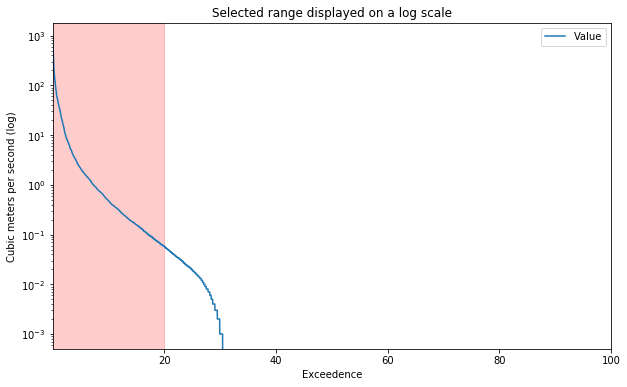

In [4]:
# The lat and lon takes the location of the gauge. You can change the lat 
# and lon to a different location if necessary, just comment out out this 
# lat, lon = pos line below and define your own.
lat, lon = station.pos

# lat =
# lon =

# The buffer is how many meters radius around the location you want to display.
buffer = 15000

# Rearranging data into a flow duration curve
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1 - (gauge_data.rownumber / len(gauge_data))) * 100

# What part of the Flow Duration Curve do you want to look at?
xaxis_lower_parameter = 0
xaxis_higher_parameter = 20

# Plot the data on a log scale
gauge_data.plot(x='Exceedence',
                y='Value',
                logy=True,
                title='Selected range displayed on a log scale',
                figsize=(10, 6))
plt.axvspan(xaxis_lower_parameter,
            xaxis_higher_parameter,
            color='red',
            alpha=0.2)
plt.ylabel('Cubic meters per second (log)');

## Query, Dask load and merge
The output of this next box will tell you how many satellite passes you are about to load and the lat and lon of the area you are generating an image of. The query in this box should have the time set from 1987 to present, we want to load all the data here. The part where you choose the epochs comes later. 

In [5]:
# Set up a query which includes ALL satellite data from 1987
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1987-01-01', '2019-11-01'), # Change this date to match present day
         'crs': 'EPSG:3577'} 

# Dask load wofs_albers data (this loads the dataset parameters only, 
# not the actual satellite data)
wofs_albers = dc.load(product = 'wofs_albers', 
                      dask_chunks = {}, 
                      group_by='solar_day', 
                      **query)


# Merging satellite data with gauge data by timestamp
gauge_data_xr = gauge_data.to_xarray()
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time, method='nearest')

# Here is where it takes into account user input for the FDC
specified_level = merged_data.where((merged_data.Exceedence > xaxis_lower_parameter) & 
                                    (merged_data.Exceedence < xaxis_higher_parameter), 
                                    drop=True)

# Get list of dates to keep
date_list = specified_level.time.values

print(f'You are about to load {specified_level.time.shape[0]} satellite passes')

print(f'lat = {lat}')
print(f'lon = {lon}')

You are about to load 301 satellite passes
lat = -30.76198
lon = 149.98451


## Generate images of before and after
Here's the part where you choose the epochs you are interested in comparing (where it says #Change according to date legislation became effective). This step will also load and cloud mask those satellite passes and generate 3 images: one for the 'before' epoch and one for the 'after' epoch ie according to the dates  in the query and a delta image, which shows the change in water frequency of 'before' minus 'after' on a blue to red scale. Blue means water occured after legislation and red means water occured before legislation. 

The Before image is made of 173 satellite passes
The After image is made of 77 satellite passes


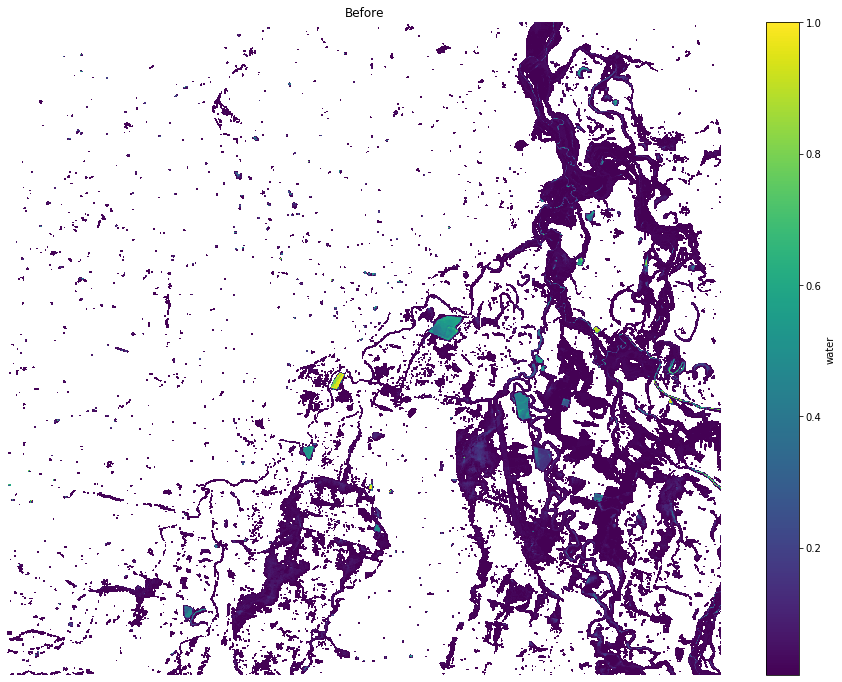

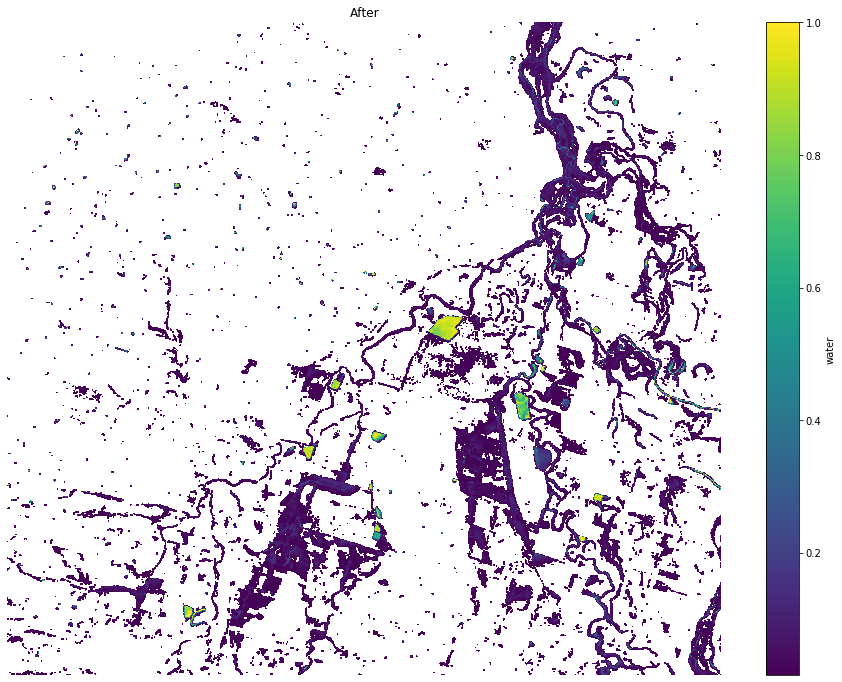

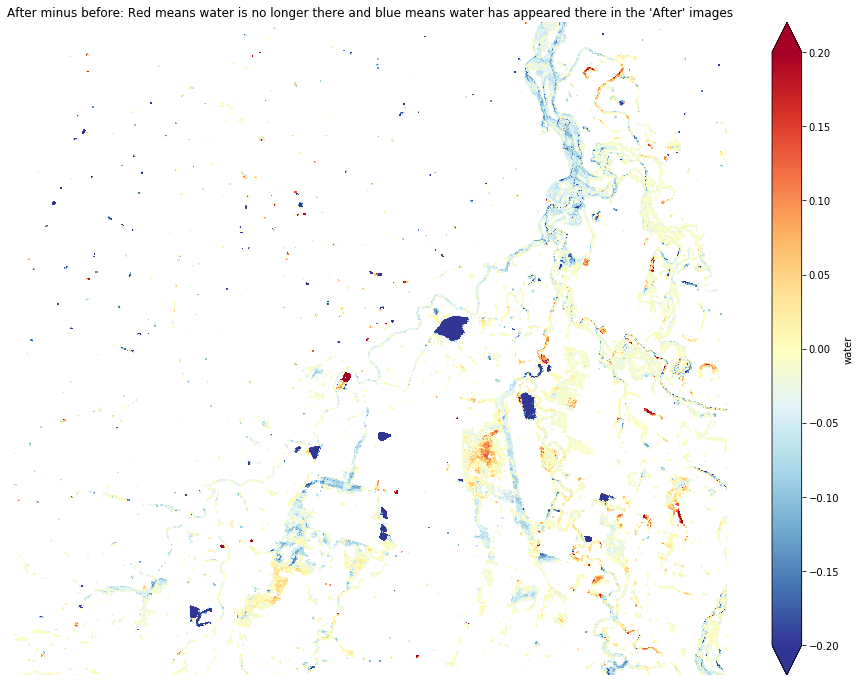

In [6]:
# Load the passes that happened during the specified flow parameters
specified_passes = wofs_albers.sel(time=date_list).compute()

# Cloudmask
cc = masking.make_mask(specified_passes.water, cloud=True)
ncloud_pixels = cc.sum(dim=['x', 'y'])
npixels_per_slice = (specified_passes.water.shape[1] * 
                     specified_passes.water.shape[2])
cloud_pixels_fraction = (ncloud_pixels / npixels_per_slice)
clear_specified_passes = specified_passes.water.isel(
    time=cloud_pixels_fraction < 0.5)


# Split by date into before and after legislation about floodplain harvesting
query_dates = clear_specified_passes

before_legislation = query_dates.loc[dict(time=slice('1987-01-01', '2008-06-01'))] # Change according to date legislation became effective
after_legislation = query_dates.loc[dict(time=slice('2008-06-02', '2019-11-13'))]

print(f'The Before image is made of {before_legislation.time.shape[0]} satellite passes')
print(f'The After image is made of {after_legislation.time.shape[0]} satellite passes')

#Create parameters for the image
wet = (before_legislation == 128).sum(dim='time')
dry = (before_legislation == 0).sum(dim='time')
clear = wet + dry
frequency_before = wet / clear
frequency_before = frequency_before.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency_before = frequency_before.where(frequency_before !=0) #This is to tell it to make areas that were dry 100% of the time white

#Plotting the image
frequency_before.plot(figsize = (16, 12))
plt.axis('off')
plt.title('Before')
plt.show()


#Create parameters for the image
wet = (after_legislation == 128).sum(dim='time')
dry = (after_legislation == 0).sum(dim='time')
clear = wet + dry
frequency_after = wet / clear
frequency_after = frequency_after.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency_after = frequency_after.where(frequency_after !=0) #This is to tell it to make areas that were dry 100% of the time white

#Plotting the image
frequency_after.plot(figsize = (16, 12))
plt.axis('off')
plt.title('After')
plt.show()

delta = frequency_before - frequency_after

# Plotting the image
delta.plot(figsize = (16, 12), vmin = -0.2, vmax = 0.2, cmap = 'RdYlBu_r')
plt.axis('off')
plt.title("After minus before: Red means water is no longer there and blue means water has appeared there in the 'After' images")
plt.show()

# Check the distribution of the 'before' and 'after' passes
To get a better understanding of the delta image, you might want to check the distribution of the 'before' and 'after' passes along the flow duration curve to get an idea if the results might be skewed. This part isn't automated to select the same dates yet, so please re-enter your before and after dates again.

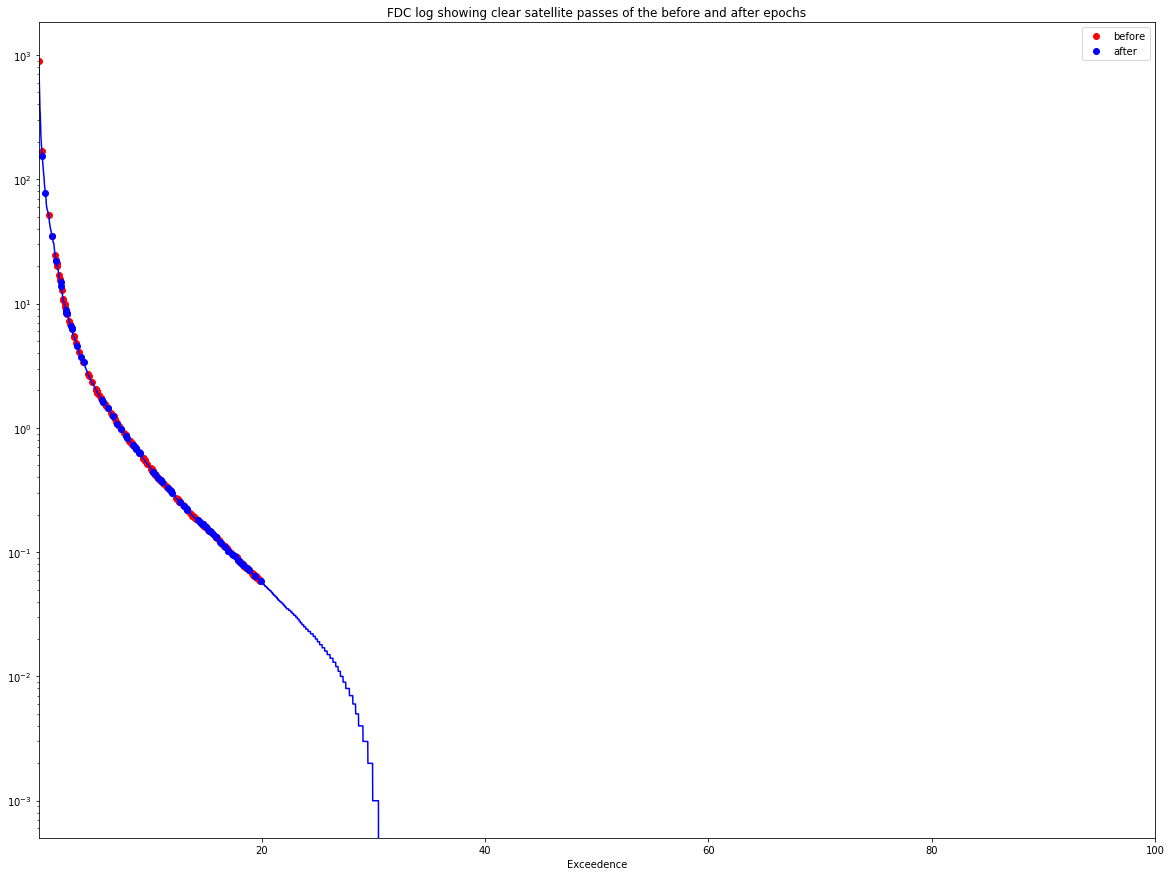

In [8]:
#Now take the clear passes and make a pandas dataframe that lists time of clear passes and corresponding gauge value
clear_specified_passes_pd = clear_specified_passes.time.to_dataframe()
clear_specified_passes_pd = clear_specified_passes_pd.rename(columns = {'time': 'date'})#can't have 2 columns called time
merged_data_pd = merged_data.to_dataframe()

#Merge clear satellite passes with gauge data by the time dimension
clear_merged_data = pd.merge(clear_specified_passes_pd, merged_data_pd, left_on= 'time', 
                            right_index=True, how='inner')
clear_merged_data = clear_merged_data.drop(columns='date')
clear_merged_data = clear_merged_data.drop(columns='Timestamp')

before = clear_merged_data['1987-01-10':'2008-06-01']
after  = clear_merged_data['2008-06-01':]

# Plot clear satellite passes with a top 20% flowrate over a flow duration curve
ax = before.plot(x='Exceedence', marker = 'o', color = 'red', linestyle='None',
                y='Value',
                logy=True,
                title='FDC log showing clear satellite passes of the before and after epochs', figsize = (20,15))
after.plot(x='Exceedence', logy=True, y='Value', ax=ax, marker = 'o', color = 'blue', linestyle='None')
gauge_data.plot(x='Exceedence', y='Value', logy=True, ax=ax, color = 'blue')
ax.legend(["before", "after"]);

## Save the delta image as a GeoTIFF
The ../ part of the file name means your .tif file will be saved one folder up from where this notebook is saved. Choose an appropriate file name. 

In [ ]:
# Set the output file name 
file_name = '../delta_image.tif'

# Set up the file for writing
delta_image = delta.to_dataset()
delta_image.attrs=wofs_albers.attrs

# Write GeoTIFF to a location
write_geotiff(file_name, delta_image)